In [98]:
import numpy as np
from SimPEG.electromagnetics import time_domain as tdem
from SimPEG import (
    optimization,
    discretize,
    maps,
    Data,
    data_misfit,
    regularization,
    inverse_problem,
    inversion,
    directives,
    utils,
)
import matplotlib.pyplot as plt
import tem
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn import preprocessing


## Pull in raw data ##

In [122]:
st = 14 # station of interest
usfFile = "/Users/natalie/Documents/tapirTEM/RAW/20210628_155033_886_Station"+str(st)+".usf"

# Data channels (low moment (lm) and high moment (hm))
# m = 1 # lm 
# m = 2 # hm
# m = 3 # lm
m = 4 # hm

if m == 1:
    print("Data is Low Moment from RC-5 reciever")
    stn = tem.Sounding(usfFile);
    quality = stn.channels[1]["q"];
    c = stn.channels[1]["a"]; 
    std = []
    times = []
    dobs = []
    for i in range(len(quality)):
        if (quality[i] == 1):
            std.append(stn.channels[1]["std"][i]);
            times.append(stn.channels[1]["t"][i]);
            dobs.append(stn.channels[1]["v"][i]);
elif m == 2:
    print("Data is High Moment from RC-5 reciever")
    stn = tem.Sounding(usfFile);
    quality = stn.channels[2]["q"];
    c = stn.channels[2]["a"] 
    std = []
    times = []
    dobs = []
    for i in range(len(quality)):
        if (quality[i] == 1):
            std.append(stn.channels[2]["std"][i])
            times.append(stn.channels[2]["t"][i])
            dobs.append(stn.channels[2]["v"][i])
elif m == 3:
    print("Data is Low Moment from RC-200 reciever")
    stn = tem.Sounding(usfFile);
    quality = stn.channels[3]["q"]
    c = stn.channels[3]["a"] 
    std = []
    times = []
    dobs = []
    for i in range(len(quality)):
        if (quality[i] == 1):
            std.append(stn.channels[3]["std"][i])
            times.append(stn.channels[3]["t"][i])
            dobs.append(stn.channels[3]["v"][i])
else:
    print("Data is High Moment from RC-200 reciever")
    stn = tem.Sounding(usfFile);
    quality = stn.channels[4]["q"];
    c = stn.channels[4]["a"]; 
    std = []
    times = []
    dobs = []
    for i in range(len(quality)):
        if (quality[i] == 1):
            std.append(stn.channels[4]["std"][i]);
            times.append(stn.channels[4]["t"][i]);
            dobs.append(stn.channels[4]["v"][i]);
        


Data is High Moment from RC-200 reciever
     SWEEP_NUMBER  CURRENT  FREQUENCY  SWEEP_IS_NOISE        DATE  DAYTIME  \
0             1.0     2.22      240.0             0.0  20210628.0    15.85   
1             2.0     2.22      240.0             0.0  20210628.0    15.85   
2             3.0     2.22      240.0             0.0  20210628.0    15.85   
3             4.0     2.22      240.0             0.0  20210628.0    15.86   
4             5.0     2.22      240.0             0.0  20210628.0    15.86   
..            ...      ...        ...             ...         ...      ...   
219         220.0     0.00      240.0             1.0  20210628.0    15.97   
220         221.0     0.00       15.0             1.0  20210628.0    15.84   
221         222.0     0.00       15.0             1.0  20210628.0    15.88   
222         223.0     0.00       15.0             1.0  20210628.0    15.92   
223         224.0     0.00       15.0             1.0  20210628.0    15.97   

     COIL_SIZE  FIELD_

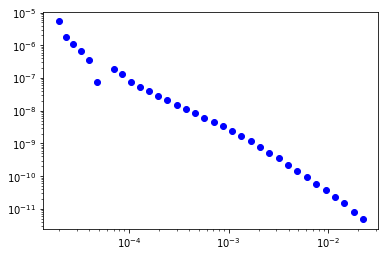

In [123]:
# Take an initial look at the data 
plt.loglog(times, dobs,"bo",label='observed')

## Create Simulation ##

In [5]:
def Foreland_TEMsim(cs, ncx, ncz, npad, layerz,Mtx, times, sig_half, sig_layer1, 
                    sig_layer2, sig_layer3):
    
    # padded cyl mesh
    hx = [(cs, ncx), (cs, npad, 1.3)]
    hz = [(cs, npad, -1.3),(cs, ncz)]
    mesh = discretize.CylMesh([hx, 1, hz],'00N')
                    
    # Conductivity model
    active = mesh.vectorCCz < 0.
    layer1 = (mesh.vectorCCz >= layerz[0])
    layer2 = (mesh.vectorCCz <= layerz[0]) & (mesh.vectorCCz >= layerz[1])
    layer3 = (mesh.vectorCCz <= layerz[1]) & (mesh.vectorCCz >= layerz[2])
    layer4 = (mesh.vectorCCz <= layerz[2])
    
    sigma = np.ones(mesh.nCz)*sig_half
    sigma[active] = sig_half
    
    sigma[layer1] = sig_layer1
    sigma[layer2] = sig_layer2
    sigma[layer3] = sig_layer3
    
    # Mapping
    actMap = maps.InjectActiveCells(mesh, active, np.log(sig_half), nC=mesh.nCz)
    mapping = maps.ExpMap(mesh) * maps.SurjectVertical1D(mesh) * actMap
    mtrue = np.log(sigma[active])
    
    
    rxOffset = 0
    rx = tdem.Rx.PointMagneticFluxTimeDerivative(np.array([[0, 0, 0]]), times, "z")
    src = tdem.Src.MagDipole([rx], loc=np.array([0.0, 0.0, 0.0]), moment = Mtx)
    surveyTD = tdem.Survey([src])
    rel_err = 0.05
    simulation = tdem.Simulation3DMagneticFluxDensity(mesh, survey=surveyTD, sigmaMap=mapping, time_steps=times)
    
    # True date
    dtrue = simulation.dpred(mtrue)
    # Observed data
    obs_data = [(i*c) for i in dobs]

    return dtrue, obs_data
                    

## Model Response ##

/Users/natalie/opt/anaconda3/envs/geoenv/lib/python3.9/site-packages/SimPEG/utils/code_utils.py:413: FutureWarning: loc has been deprecated, please use location. It will be removed in version 0.16.0 of SimPEG.
  warnings.warn(message, FutureWarning)
/Users/natalie/opt/anaconda3/envs/geoenv/lib/python3.9/site-packages/SimPEG/utils/code_utils.py:420: FutureWarning: loc has been deprecated, please use location. It will be removed in version 0.16.0 of SimPEG.
  warnings.warn(message, FutureWarning)
/Users/natalie/opt/anaconda3/envs/geoenv/lib/python3.9/site-packages/SimPEG/utils/code_utils.py:413: FutureWarning: loc has been deprecated, please use location. It will be removed in version 0.16.0 of SimPEG.
  warnings.warn(message, FutureWarning)
/Users/natalie/opt/anaconda3/envs/geoenv/lib/python3.9/site-packages/SimPEG/utils/code_utils.py:420: FutureWarning: loc has been deprecated, please use location. It will be removed in version 0.16.0 of SimPEG.
  warnings.warn(message, FutureWarning)


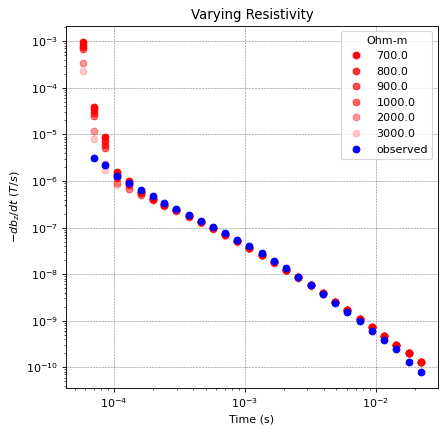

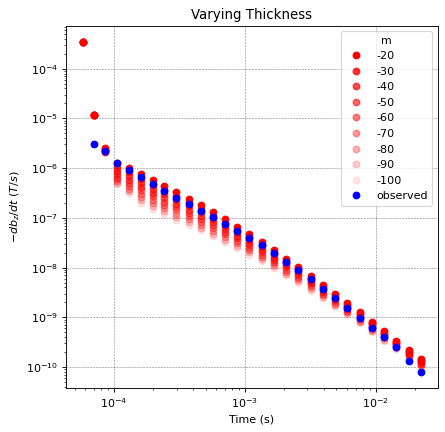

In [171]:
# Define cylindrical mesh properties
cs, ncx, ncz, npad = 5.0, 50, 50, 15

# Set tx loop magnetic moment
#A = 10000 # area of tx loop used m^2
A = 1600
# A = 400

N = 1 # turns of coil in tx loop
Mtx = N*c*A # magnetic moment

n = 6 # number of initial "ringy" data points to cut off before plotting




### PARAMETERS FOR VARYING RESISTIVITY ###
# Set geological model layer boundaries below surface
b1 = -40
b2 = -100
b3 = -150
b4 = -2000
layerz = np.r_[b1, b2, b3, b4]

# Set model layer conductivities
L1 = [700, 800, 900, 1000, 2000, 3000] # choose a range of 6 Ohm*m values for layer 1
L1 = np.array(L1,dtype=float)
sig_layer1 = np.reciprocal(L1)

L2 = 5000
L2 = np.array(L2,dtype=float) # choose a single Ohm*m value for layer 2
L2 = np.reciprocal(L2)

L3 = 1000
L3 = np.array(L3,dtype=float) # choose a single Ohm*m value for layer 3
L3 = np.reciprocal(L3)

Hs = 20
Hs = np.array(Hs,dtype=float) # choose a single Ohm*m value for the half space
Hs = np.reciprocal(Hs)

### PARAMETERS FOR VARYING THICKNESS ###
Thk2 = abs(b2-b1) # choose layer 2 thickness
Thk3 = abs(b3-b2) # choose layer 3 thickness

b1 = [-20,-30,-40,-50,-60,-70,-80,-90,-100] # choose a range of 9 thickness values for layer 1
b2 = [i - Thk2 for i in b1]
b3 = [i - Thk3 for i in b2]
b4 = -2000
    
    
    
    

### RUN SIMULATIONS ### 
data1 = []
for i in range(len(sig_layer1)):
    dtrue1, obs_data1 = Foreland_TEMsim(cs, ncx, ncz, npad, 
                             layerz, 
                             Mtx, 
                             times, 
                             sig_half=Hs, 
                             sig_layer1=sig_layer1[i], 
                             sig_layer2=L2, 
                             sig_layer3=L3)
    data1.append(dtrue1) 
    


plt.figure(figsize=(6, 6), dpi=80)
plt.loglog(times[n:], -data1[0][n:], "ro",alpha=1.0, label=str(L1[0]))
plt.loglog(times[n:], -data1[1][n:], "ro",alpha=0.8,label=str(L1[1]))
plt.loglog(times[n:], -data1[2][n:], "ro",alpha=0.7,label=str(L1[2]))
plt.loglog(times[n:], -data1[3][n:],"ro",alpha=0.6,label=str(L1[3]))
plt.loglog(times[n:], -data1[4][n:],"ro",alpha=0.4,label=str(L1[4]))
plt.loglog(times[n:], -data1[5][n:],"ro",alpha=0.2,label=str(L1[5]))

plt.loglog(times[n:], obs_data1[n:],"bo",label='observed')

plt.title('Varying Resistivity')
plt.ylabel("$-db_{z}/dt$ $(T/s)$")
plt.xlabel("Time (s)")
plt.grid(color="k", alpha=0.5, linestyle="dashed", linewidth=0.5)
plt.legend(title='Ohm-m')
plt.savefig('G1st14_cond.png')




data2 = []
for i in range(len(b1)):
    layerz = np.r_[b1[i], b2[i], b3[i], b4]
    dtrue2, obs_data2 = Foreland_TEMsim(cs, ncx, ncz, npad, 
                             layerz, 
                             Mtx, 
                             times, 
                             sig_half=Hs, 
                             sig_layer1=sig_layer1[4], 
                             sig_layer2=L2,
                             sig_layer3=L3)          
    data2.append(dtrue2)


plt.figure(figsize=(6, 6), dpi=80)
plt.loglog(times[n:], -data2[0][n:], "ro",alpha=1.0, label=str(b1[0]))
plt.loglog(times[n:], -data2[1][n:], "ro",alpha=0.8,label=str(b1[1]))
plt.loglog(times[n:], -data2[2][n:], "ro",alpha=0.7,label=str(b1[2]))
plt.loglog(times[n:], -data2[3][n:],"ro",alpha=0.6,label=str(b1[3]))
plt.loglog(times[n:], -data2[4][n:],"ro",alpha=0.5,label=str(b1[4]))
plt.loglog(times[n:], -data2[5][n:],"ro",alpha=0.4,label=str(b1[5]))
plt.loglog(times[n:], -data2[6][n:],"ro",alpha=0.3,label=str(b1[6]))
plt.loglog(times[n:], -data2[7][n:],"ro",alpha=0.2,label=str(b1[7]))
plt.loglog(times[n:], -data2[8][n:],"ro",alpha=0.1,label=str(b1[8]))

plt.loglog(times[n:], obs_data2[n:],"bo",label='observed')

plt.title('Varying Thickness')
plt.ylabel("$-db_{z}/dt$ $(T/s)$")
plt.xlabel("Time (s)")
plt.grid(color="k", alpha=0.5, linestyle="dashed", linewidth=0.5)
plt.legend(title='m')
plt.savefig('G1st14_thk.png')


## Compute RMSE ##

Text(0.5, 1.0, 'Data misfit for thickness models')

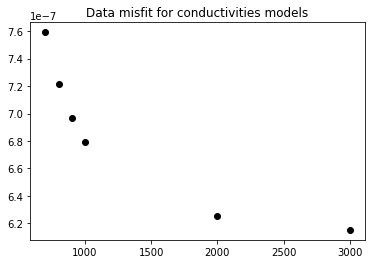

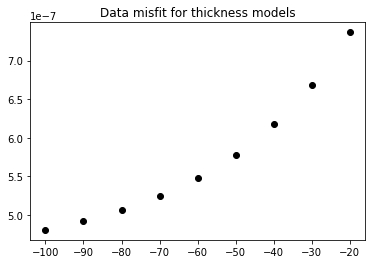

In [162]:
def cost_fun(data, obs_data):
    
    rms = []
    
    for i in range(len(data)):
        temp = sqrt(mean_squared_error(data[i][9:], obs_data[9:]))
        rms.append(temp)
        
    return rms
    
rms_cond = cost_fun(data1, obs_data1)
rms_thick = cost_fun(data2, obs_data2)

xlab_con = [L1[0], L1[1], L1[2], L1[3], L1[4], L1[5]]

plt.figure()
plt.plot(xlab_con, rms_cond,'k.',markersize=12)
plt.title('Data misfit for conductivities models')
# plt.savefig('var_L1_cond_misfit_G4s30_v2.png')

xlab_thick = [b1[0],b1[1],b1[2],b1[3],b1[4],b1[5],b1[6],b1[7],b1[8]]

plt.figure()
plt.plot(xlab_thick, rms_thick,'k.',markersize = 12)
plt.title('Data misfit for thickness models')
# plt.savefig('var_L1_thick_misfit_G4s30_v2.png')
        